In [1]:
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import argparse
import seaborn as sns; sns.set()
import csv
import os
import time

In [2]:

f = 0
def get_csv_log(log_dirs):
    steps, values = [], []
    data = {}
    # for idx, path in enumerate(log_dirs):
    reader = csv.reader(open(log_dirs, 'r'))
    
    for row in reader:
        wall_time, step, value = row
        steps.append(step)
        values.append(value)
    steps.pop(0)
    values.pop(0)
    data["steps"] = steps
    data["values"] = values
    return data

def get_tensorflow_log(log_dirs: list, label: str):
    """Returns log files for one label"""


    # Loading too much data is slow...
    tf_size_guidance = {
        'compressedHistograms': 10,
        'images': 0,
        'scalars': 100,
        'histograms': 1
    }

    steps, values = [], []
    for idx, path in enumerate(log_dirs):
        event_acc = EventAccumulator(path, tf_size_guidance)
        event_acc.Reload()

        # Show all tags in the log file
        #print(event_acc.Tags())
        assert label in event_acc.Tags()["scalars"], "Selected label: {} does not exist in the list of selectable labels:\n {}".format(label, event_acc.Tags()["scalars"])

        # get data by label
        d =   event_acc.Scalars(label)
        #data[label+"_"+str(idx)] = d
        
        for i in range(len(d)):
            steps.append(d[i][1])
            values.append(d[i][2])
    data = {}

    data["steps"] = steps
    data["values"] = values
    return data

def create_dataset(data: dict, label:str):
    d = {'Episodes': np.hstack(data["steps"]), label :np.hstack(data["values"])}
    data = pd.DataFrame(data=d)
    return data

In [3]:
def smooth(scalars , weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


In [4]:
def sort(order,data_sets,algorithm):
    for i in range(len(order)):
        for j in range(len(order) - 1):
            if order[j] > order[j+1]:
                # Swap
                order[j], order[j+1] = order[j+1], order[j]
                data_sets[j], data_sets[j+1] = data_sets[j+1], data_sets[j]
                algorithm[j], algorithm[j+1] = algorithm[j+1], algorithm[j]
    return data_sets,algorithm

In [5]:
def swap(data_sets, algorithm, i, j):
    data_sets[i], data_sets[j] = data_sets[j], data_sets[i]
    algorithm[0][i], algorithm[0][j] = algorithm[0][j], algorithm[0][i]
    return data_sets,algorithm
    
def plot(data_sets, title, algorithm, label, dir,xlimit,ymin,lunar,order,more_colors):
    if order != None:
        data_sets,algorithm = sort(order,data_sets,algorithm)


    plot_i(data_sets, title, algorithm, label, dir,xlimit,ymin,8,lunar,more_colors)
    plot_i(data_sets, title, algorithm, label, dir,xlimit,ymin,15,lunar,more_colors)
    plt.show()
    # time.sleep(3)
    # plt.close()

In [6]:

def plot_i(data_sets, title, algorithm, label, dir,xlimit,ymin,figs,lunar,more_colors):
    global f
    f+=1
    fig = plt.figure(f,figsize=(8,8))
    # plt.clf()
    # plt.subplot(111)
    ax1 = plt.gca()
    
    plt.ticklabel_format(style='sci', axis='x',useOffset=False, scilimits=(0,0))
    max_ = -100000
    if more_colors:
        colors =['crimson','lime','deepskyblue','magenta','darkviolet','darkorange','yellow','chocolate']
    for idx, data in enumerate(data_sets):
        plt.figure(f)
        data=data.astype(float)
        if xlimit!=None:
            data = data.drop(data[data.values[...,0] > xlimit].index)
        
        smoothed = data.copy()
        smoothed.values[...,1] = smooth(smoothed.values[...,1],0.9)
        max_ = max(np.amax(data.values[...,1]),max_)

        std = np.std(rolling_window(data.values[...,1], 30), axis=-1)

        
        if not more_colors:
            color = next(ax1._get_lines.prop_cycler)['color']
        else:
            color = colors[idx]
        ax = data.plot(x='Episodes', y=label,alpha=0.3,color=color,label='',figsize=(figs, 8),ax = ax1)
        smoothed.plot(x='Episodes', y=label,alpha=1.0,color=color,ax = ax1,label=algorithm[idx],linewidth=2.0)
        
        # color = next(ax1._get_lines.prop_cycler)['color']
#         plt.fill_between(data.values[...,0], smoothed.values[...,1]-std, smoothed.values[...,1]+std,color=color,alpha=0.1)
#         plt.fill_between(data.values[...,0], smoothed.values[...,1]-std, smoothed.values[...,1]+std,color=color,alpha=0.1)
    
    extratick = [max_]
    plt.yticks(list(plt.yticks()[0])[1:-1-int(lunar)]+extratick)
    ax.set_ylabel("avg reward")
    if figs==8:
        fsize=16
    else:
        fsize=20
    plt.title(title, fontsize=fsize)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.yaxis.label.set_size(fsize)
    ax.xaxis.label.set_size(fsize)

    plt.legend(loc='lower right',fontsize=fsize)
    if ymin!=None:
        plt.ylim(bottom=ymin) 
    
    if figs==8:
        plt.savefig(dir+title+'_square.svg', format='svg')
    else:
        plt.savefig(dir+title+'.svg', format='svg')
    # plt.show()


In [7]:
def chunks(l, n):
    out = []
    for i in range(0, len(l), n):
        out.append(l[i:i+n])
    return out

In [8]:
def create_fig(algorithm,logdir,label,title,savedir,xlim=100000000,ymin=None,lunar=False,order=None,colors=False):
    num_alg = len(algorithm)
    subdirs = sorted(os.listdir(logdir))
    subdirs_filtered = [d for d in subdirs if ".csv" in d]
    dirs = [logdir+d for d in subdirs_filtered]

    print("Process Label: ", label)
    data_per_label = []
    for j in range(num_alg):
        # data_log = get_tensorflow_log(log_dirs=dirs[j], label=label[0][i])
        data_log2 = get_csv_log(dirs[j])
        # dataset = create_dataset(data_log, label[i])
        dataset2 = create_dataset(data_log2, label)
        # data_per_label.append(dataset)
        data_per_label.append(dataset2)
    plot(data_per_label, title, algorithm, label, savedir,xlim,ymin,not lunar,order,colors)

In [9]:
%matplotlib inline

Process Label:  avg_reward/test


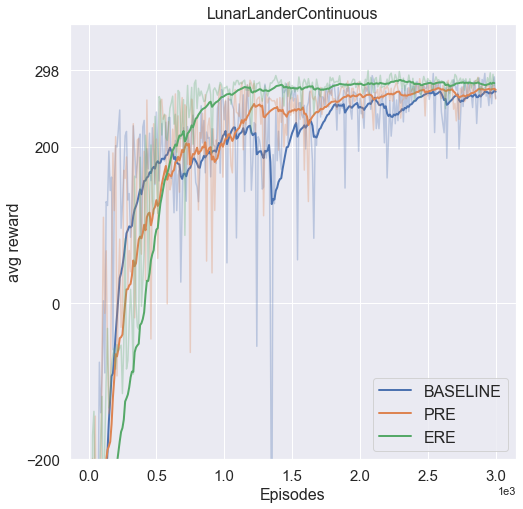

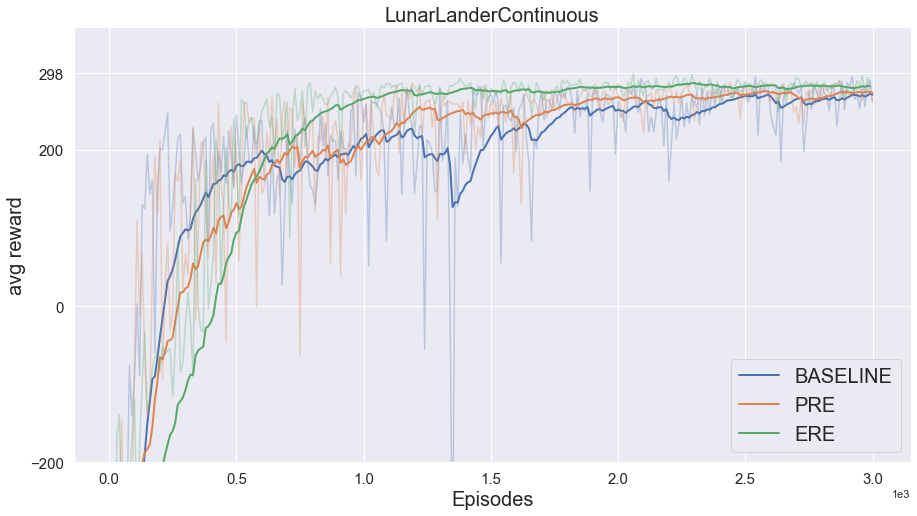

In [10]:
create_fig(["BASELINE", "PRE", "ERE"],"csv_runs/LunarLander_Baseline_PRE_ERE/","avg_reward/test","LunarLanderContinuous", "plots/",xlim=3000,lunar=True,ymin=-200)

Process Label:  avg_reward/test


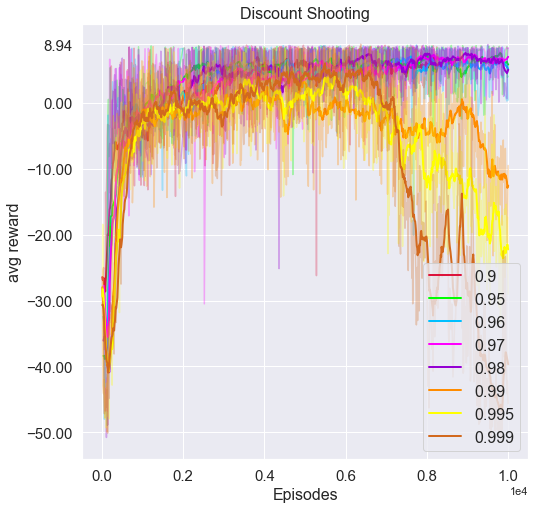

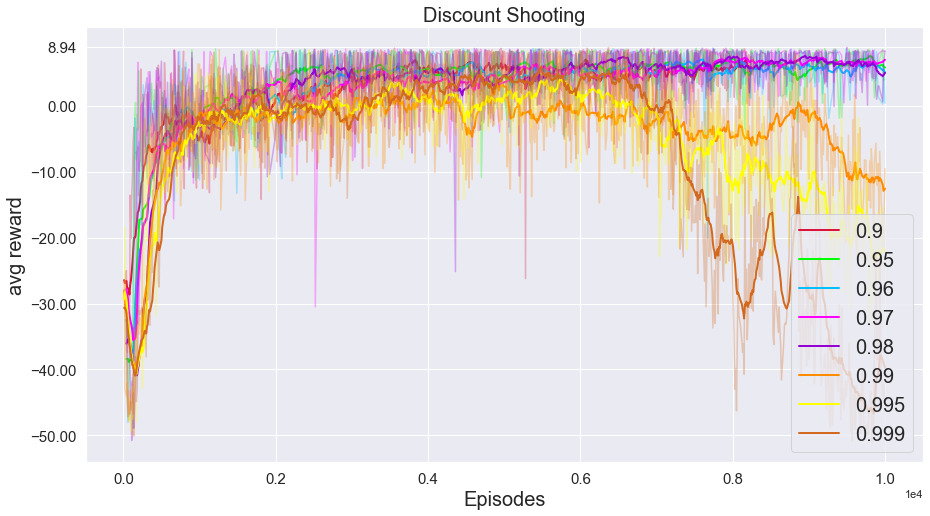

In [11]:
create_fig(["0.98", "0.99", "0.995","0.999", "0.97", "0.96","0.95", "0.9"],"csv_runs/attack_gamma/","avg_reward/test","Discount Shooting", "plots/",10000,order=[4,5,6,7,3,2,1,0],colors=True)

Process Label:  avg_reward/test


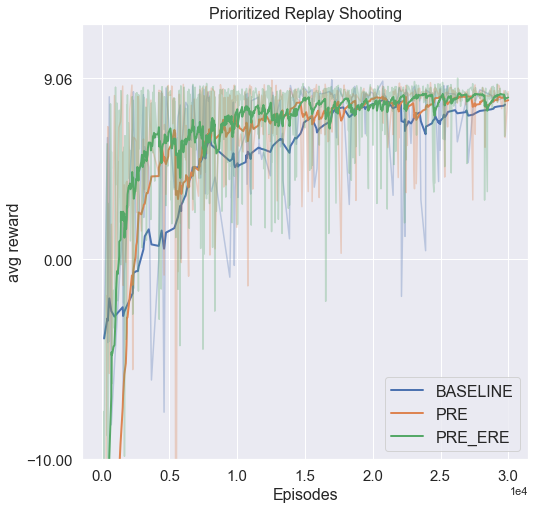

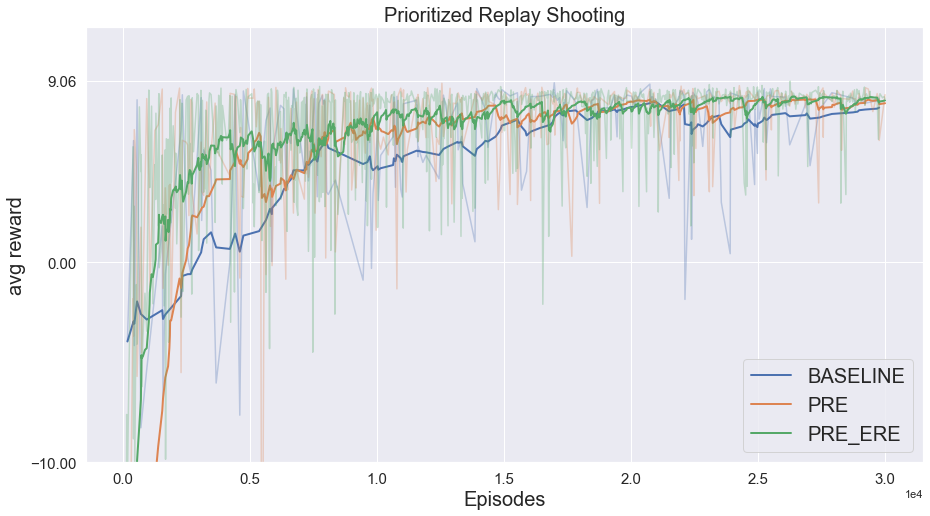

In [12]:
create_fig(["BASELINE","PRE_ERE","PRE"],"csv_runs/attack_pre_ere/","avg_reward/test","Prioritized Replay Shooting", "plots/",30000,ymin=-10,order=[0,2,1])

Process Label:  avg_reward/test


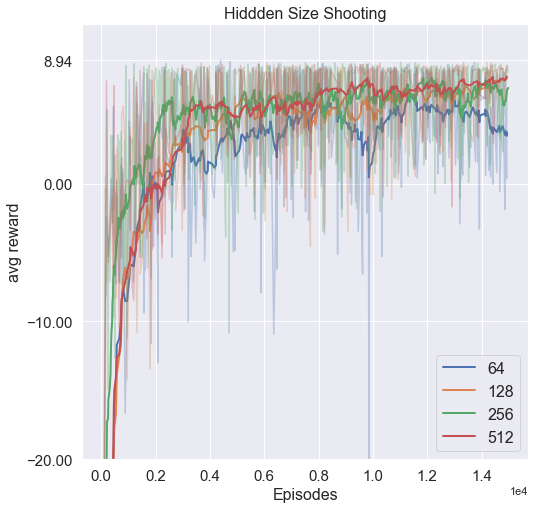

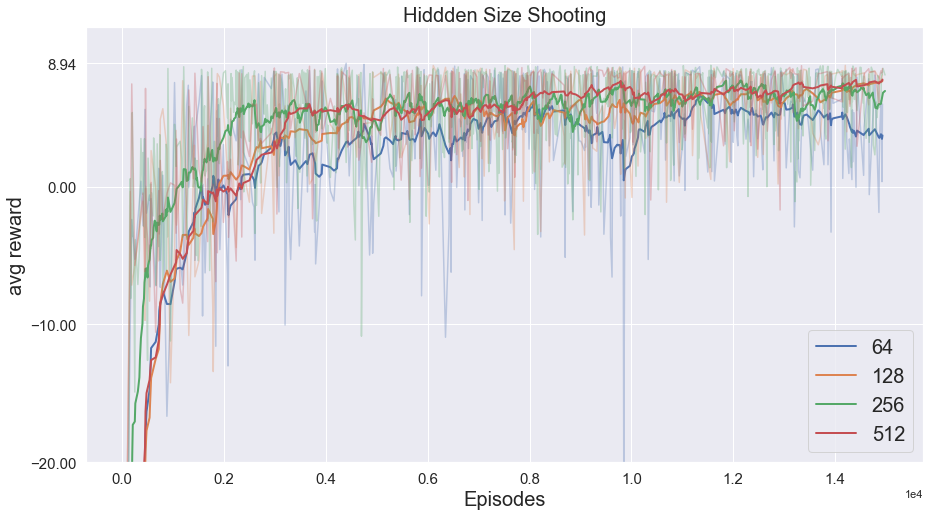

In [13]:
create_fig(["256","64","128","512"],"csv_runs/hockey-hidden-runs-attack_csv/","avg_reward/test","Hiddden Size Shooting", "plots/",15000,ymin=-20,order=[2,0,1,3])

Process Label:  avg_reward/test


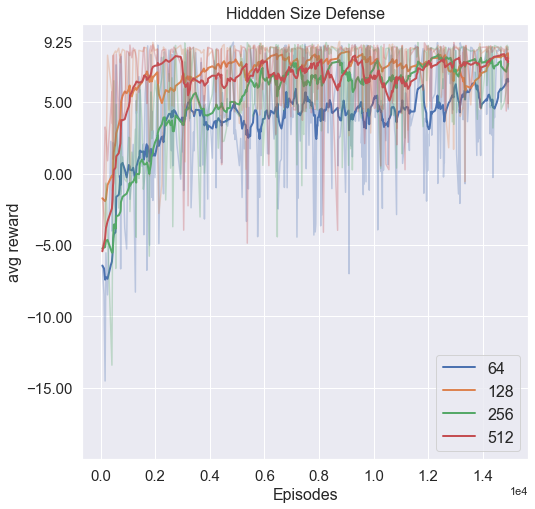

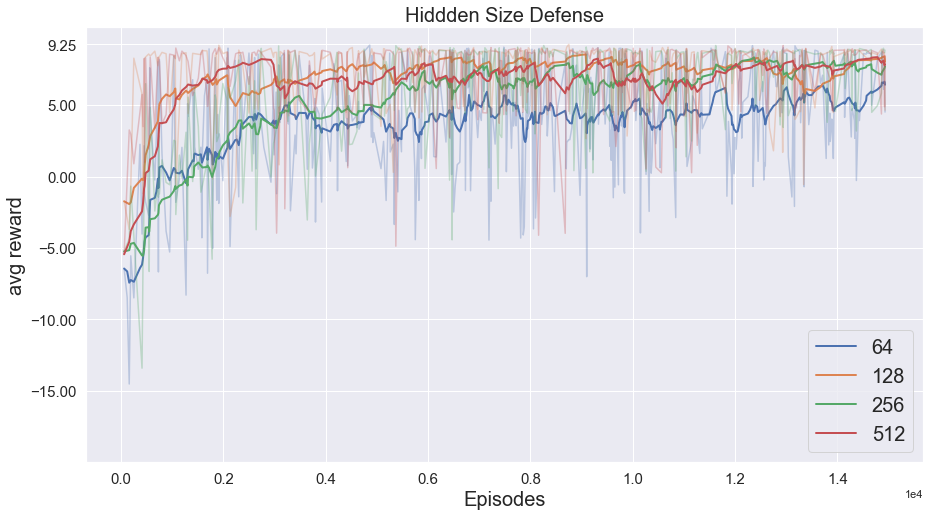

In [14]:
create_fig(["256","512","128","64"],"csv_runs/hockey-hidden-runs-defence_csv/","avg_reward/test","Hiddden Size Defense", "plots/",15000,ymin=-20,order=[2,3,1,0])

Process Label:  avg_reward/test


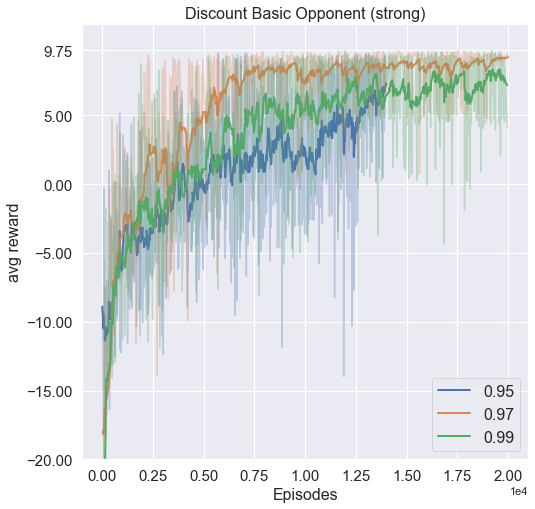

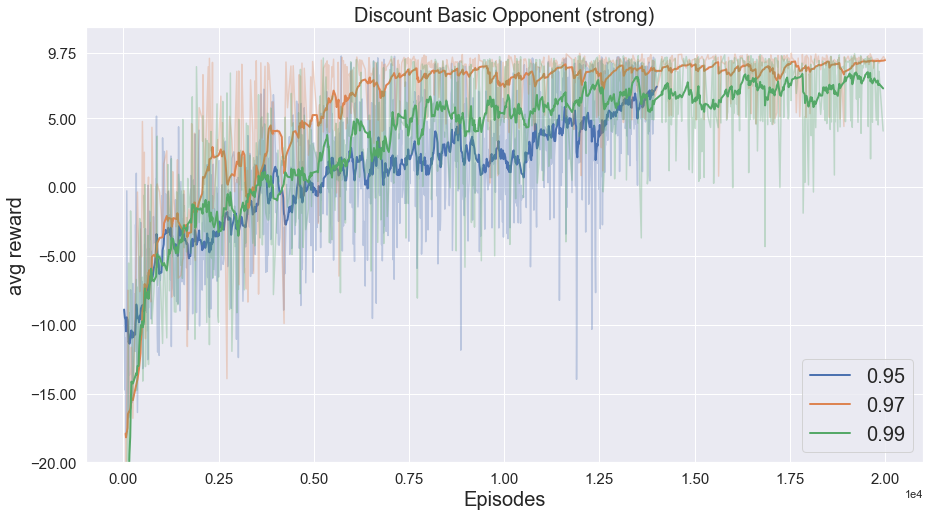

In [15]:
create_fig(["0.95","0.97","0.99"],"csv_runs/hockey-strong-gamma/","avg_reward/test","Discount Basic Opponent (strong)", "plots/",20000,ymin=-20,order=[0,1,2])

Process Label:  avg_reward/test


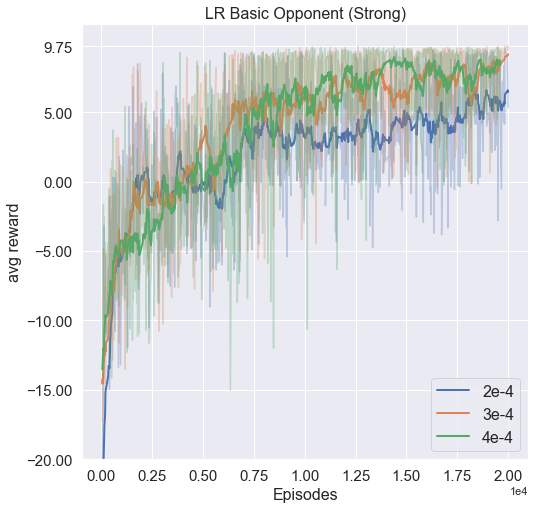

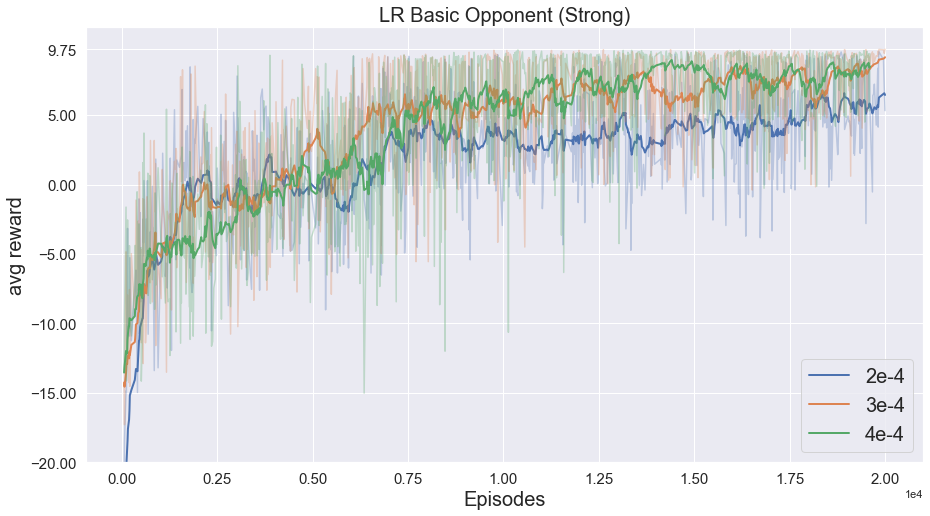

In [16]:
create_fig(["3e-4","4e-4","2e-4"],"csv_runs/strongplay_256_LR/","avg_reward/test","LR Basic Opponent (Strong)", "plots/",20000,ymin=-20,order=[1,2,0])

Process Label:  avg_reward/test


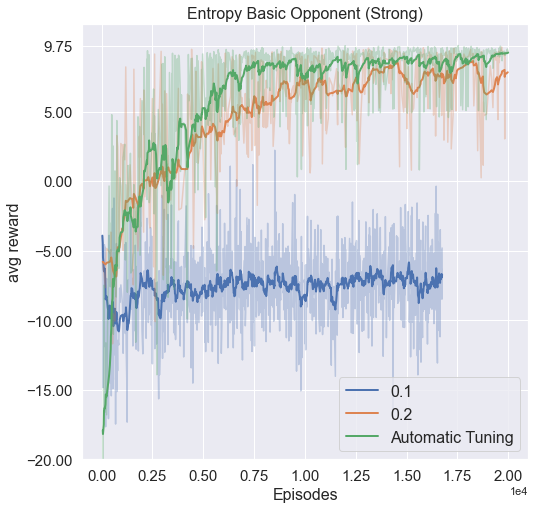

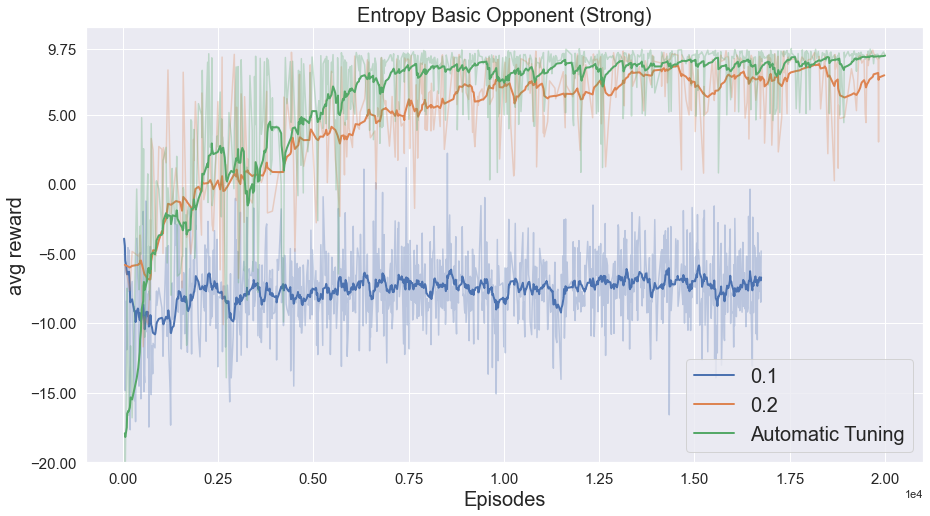

In [17]:
create_fig(["0.2","0.1","Automatic Tuning"],"csv_runs/strongplay_alpha/","avg_reward/test","Entropy Basic Opponent (Strong)", "plots/",20000,ymin=-20,order=[1,0,2])

Process Label:  avg_reward/test


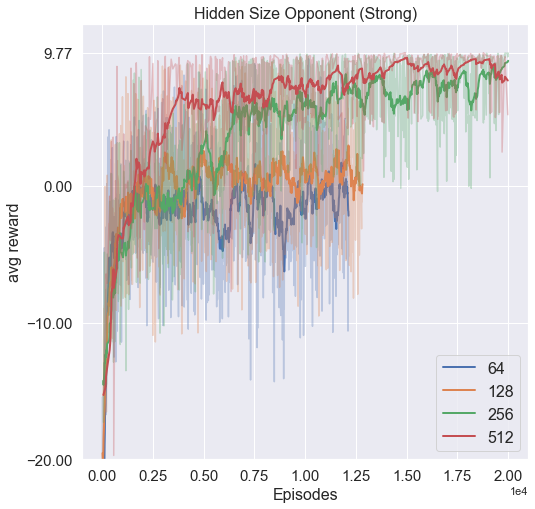

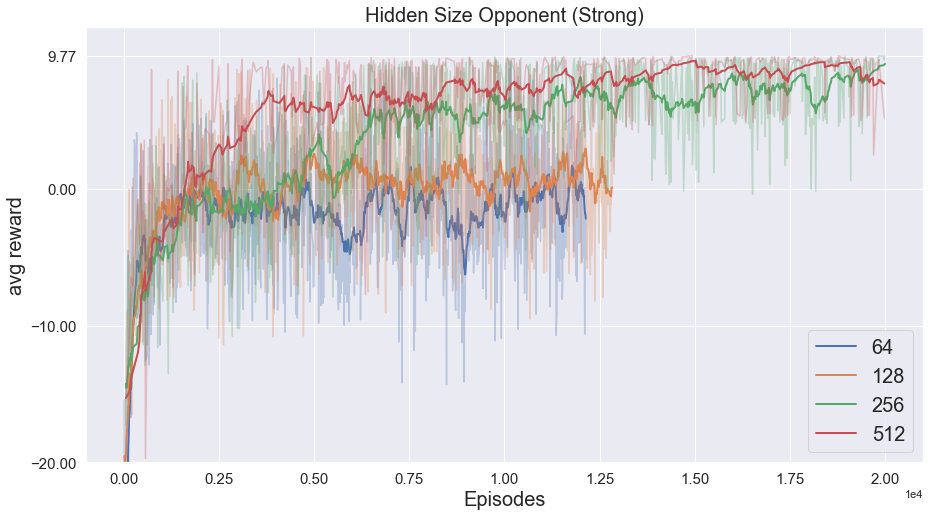

In [18]:
create_fig(["64","128","256","512"],"csv_runs/strongplay_hidd/","avg_reward/test","Hidden Size Opponent (Strong)", "plots/",20000,ymin=-20)

Process Label:  avg_reward/test


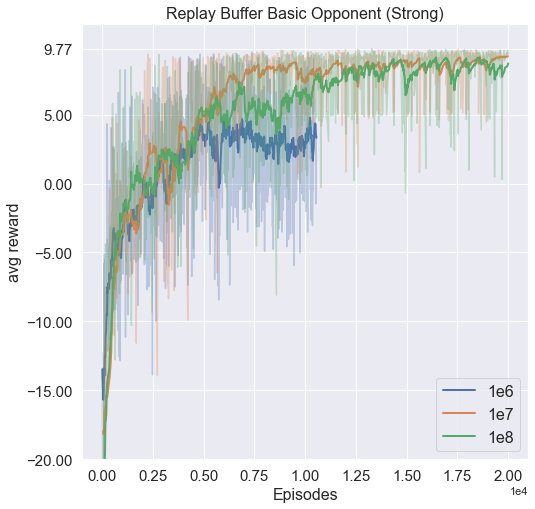

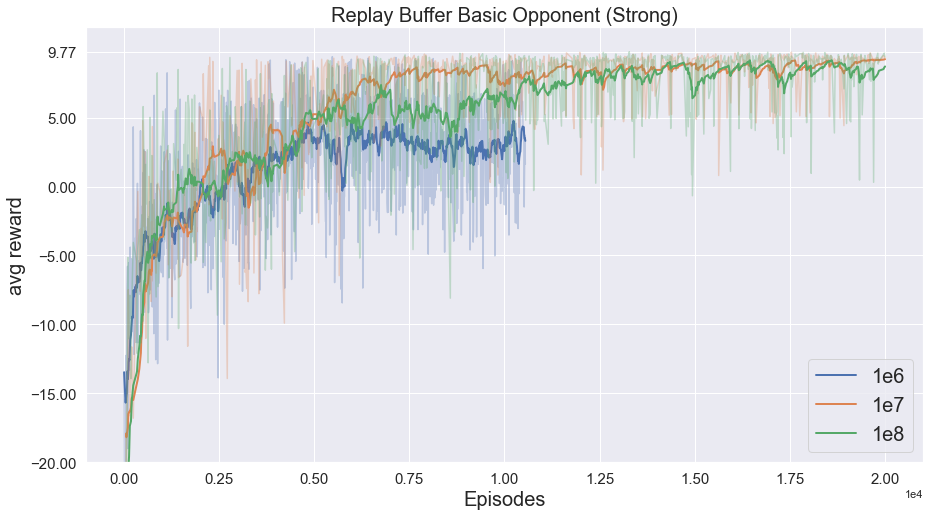

In [19]:
create_fig(["1e8","1e6","1e7"],"csv_runs/strongplay_replaybuffer/","avg_reward/test","Replay Buffer Basic Opponent (Strong)", "plots/",20000,ymin=-20,order=[2,0,1])

Process Label:  avg_reward/test


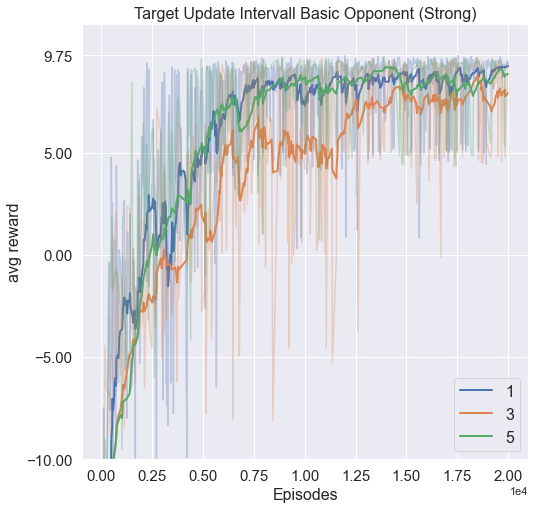

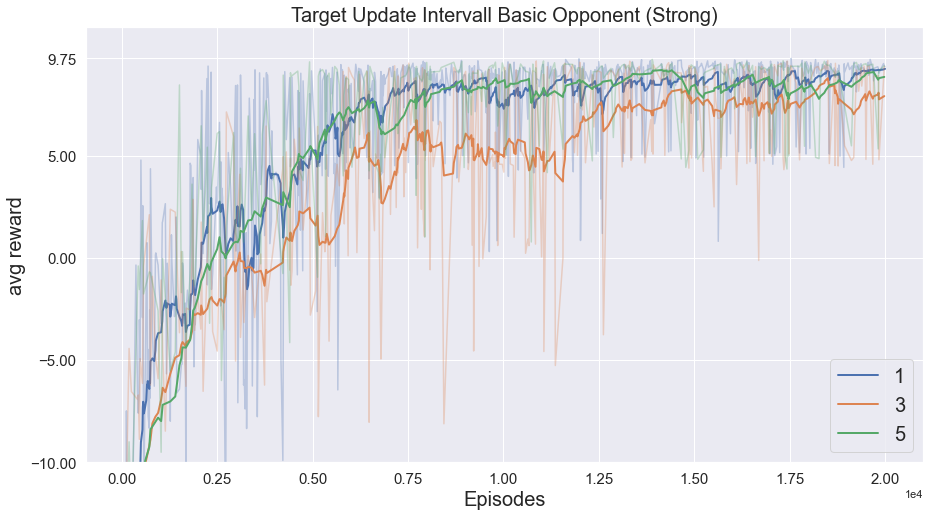

In [20]:
create_fig(["3","5","1"],"csv_runs/strongplay_target/","avg_reward/test","Target Update Intervall Basic Opponent (Strong)", "plots/",20000,ymin=-10,order=[1,2,0])

Process Label:  avg_reward/test


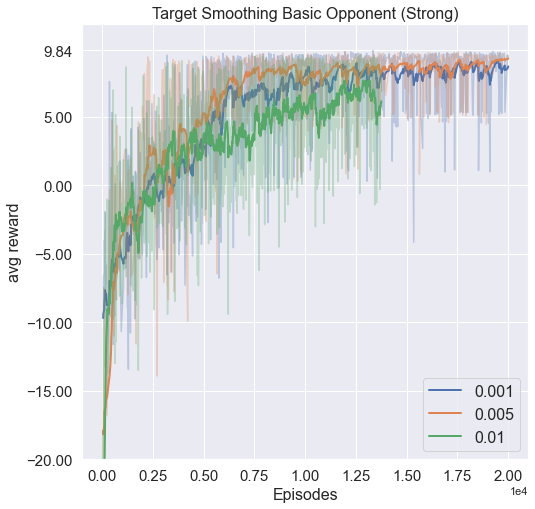

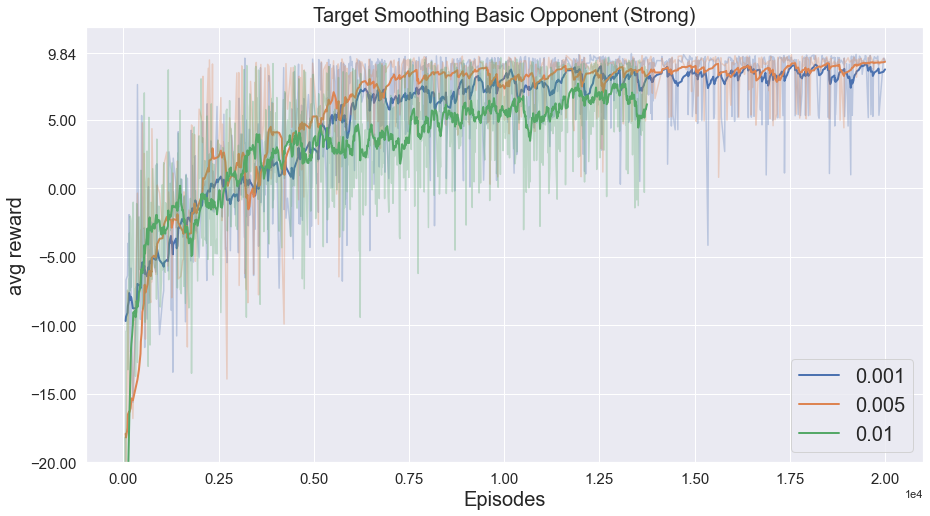

In [21]:
create_fig(["0.001","0.01","0.005"],"csv_runs/strongplay_tau/","avg_reward/test","Target Smoothing Basic Opponent (Strong)", "plots/",20000,ymin=-20,order=[0,2,1])